In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_cat_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_cat_feature.f')
print(test_.shape)

(8359, 1459)
(8360, 1454)


In [3]:
n_fold = 5

In [4]:
train_.loc[train_['Developer'].isnull(), 'Developer'] = 'None'
train_.loc[train_['Rating'].isnull(), 'Rating'] = 'None'
train_.loc[train_['Genre'].isnull(), 'Genre'] = 'None'
test_.loc[test_['Developer'].isnull(), 'Developer'] = 'None'
test_.loc[test_['Rating'].isnull(), 'Rating'] = 'None'
test_.loc[test_['Genre'].isnull(), 'Genre'] = 'None'

In [5]:
train_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,Rank_NA_Sales_by_Platform,Rank_EU_Sales_by_Platform,Rank_JP_Sales_by_Platform,Rank_Other_Sales_by_Platform,Rank_NA_Sales_by_Genre,Rank_EU_Sales_by_Genre,Rank_JP_Sales_by_Genre,Rank_Other_Sales_by_Genre,Rank_NA_Sales_by_Developer,Rank_EU_Sales_by_Developer,Rank_JP_Sales_by_Developer,Rank_Other_Sales_by_Developer,Rank_NA_Sales_by_Rating,Rank_EU_Sales_by_Rating,Rank_JP_Sales_by_Rating,Rank_Other_Sales_by_Rating,Rank_NA_Sales_by_Year,Rank_EU_Sales_by_Year,Rank_JP_Sales_by_Year,Rank_Other_Sales_by_Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,...,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0,8.0,7.0,3.135494,0,31.0,31.0,24.0,29.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056565,0.643202,0.065921,0.000142,0.103320,0.000142,0.000142,0.000142,0.000142,0.130284
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,0,7.0,8.0,3.367296,0,31.0,31.0,24.0,29.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000369,0.000369,0.286815,0.068199,0.000369,0.523832,0.037158,0.000369,0.000369,0.082150
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,0,7.0,7.0,2.397895,0,18.0,20.0,23.0,26.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056565,0.643202,0.065921,0.000142,0.103320,0.000142,0.000142,0.000142,0.000142,0.130284
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,None,None,0,NaN,NaN,NaN,0,17.0,11.0,1.0,11.0,12.0,12.0,10.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,2.0,3.0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.046832,0.000091,0.342186,0.000091,0.000091,0.342919,0.152047,0.016909,0.028151,0.070683
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,0,8.0,8.0,2.639057,0,31.0,31.0,24.0,29.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1320,3370,235,77,1420,2830,2366,96.597250,58.394680,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056565,0.643202,0.065921,0.000142,0.103320,0.000142,0.000142,0.000142,0.000142,0.130284


In [6]:
test_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,Rank_NA_Sales_by_Platform,Rank_EU_Sales_by_Platform,Rank_JP_Sales_by_Platform,Rank_Other_Sales_by_Platform,Rank_NA_Sales_by_Genre,Rank_EU_Sales_by_Genre,Rank_JP_Sales_by_Genre,Rank_Other_Sales_by_Genre,Rank_NA_Sales_by_Developer,Rank_EU_Sales_by_Developer,Rank_JP_Sales_by_Developer,Rank_Other_Sales_by_Developer,Rank_NA_Sales_by_Rating,Rank_EU_Sales_by_Rating,Rank_JP_Sales_by_Rating,Rank_Other_Sales_by_Rating,Rank_NA_Sales_by_Year,Rank_EU_Sales_by_Year,Rank_JP_Sales_by_Year,Rank_Other_Sales_by_Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,...,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,Hitman 2: Silent Assassin,XB,NaN,Action,Eidos Interactive,84.0,23.0,8.0,19.0,Io Interactive,M,0,8.0,8.0,2.995732,0,20.0,16.0,10.0,14.0,12.0,12.0,10.0,12.0,916.5,1037.0,891.5,1031.5,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000168,0.000168,0.244475,0.065020,0.000168,0.443327,0.000168,0.150225,0.000168,0.096113
1,Legacy of Kain: Soul Reaver,PS,NaN,Action,Eidos Interactive,91.0,17.0,9.0,132.0,Crystal Dynamics,T,0,9.0,9.0,4.890349,0,26.0,26.0,30.0,24.0,12.0,12.0,10.0,12.0,833.0,975.5,764.5,921.0,6.0,6.0,7.0,6.0,4.0,3.0,2.0,3.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000168,0.000168,0.244475,0.065020,0.000168,0.443327,0.000168,0.150225,0.000168,0.096113
2,Metal Gear Solid 2: Substance,XB,NaN,Action,Konami Digital Entertainment,87.0,28.0,8.5,39.0,KCEJ,M,0,8.0,9.0,3.688879,0,20.0,16.0,10.0,14.0,12.0,12.0,10.0,12.0,NaN,NaN,NaN,NaN,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.028815,0.077305,0.334698,0.010631,0.278875,0.009451,0.024971,0.091115,0.144099
3,Silent Hill: Homecoming,X360,NaN,Action,Konami Digital Entertainment,70.0,54.0,6.9,180.0,Double Helix Games,M,0,7.0,7.0,5.198497,0,30.0,27.0,14.0,27.0,12.0,12.0,10.0,12.0,990.0,1027.0,955.5,1021.0,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,1262,3370,834,22,1563,1634,2019,81.399660,61.011474,96.410622,66.212871,48.703390,82.083333,150.326531,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.028815,0.077305,0.334698,0.010631,0.278875,0.009451,0.024971,0.091115,0.144099
4,Silent Hill: Homecoming,PS3,NaN,Action,Konami Digital Entertainment,71.0,41.0,6.9,143.0,Double Helix Games,M,0,7.0,7.0,4.969813,0,27.0,29.0,22.0,30.0,12.0,12.0,10.0,12.0,990.0,1027.0,955.5,1021.0,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,1331,3370,834,22,1563,1634,2019,71.405910,61.011474,96.410622,66.212871,48.703390,92.162562,129.969925,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.028815,0.077305,0.334698,0.010631

In [7]:
cat_params = {
    'depth' : 6,
    'learning_rate' : 0.01, 
    'eval_metric' :'RMSE', 
    'random_seed' :0,
    'num_boost_round': 10000,
}

In [8]:
categorical_features = ['Platform', 'Genre', 'Developer', 'Rating']

In [9]:
def train_catboost(X, y, group, params: dict, verbose=100):

    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = list(fold.split(X)) 
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[idx_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [10]:
def train_catboost_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        train_pool = Pool(data=x_train, 
                                        label=y_train, 
                                        cat_features=categorical_features)
        validate_pool = Pool(data=x_valid, 
                                            label=y_valid, 
                                            cat_features=categorical_features)
        cat_model = CatBoostRegressor(**params)
        cat_model.fit(train_pool, eval_set=validate_pool, 
                                  verbose=verbose, 
                                  use_best_model=True,
                                  early_stopping_rounds=verbose)
        y_pred = cat_model.predict(validate_pool)
        
        oof_pred[is_valid] = y_pred
        models.append(cat_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [11]:
def train_pred(train_df, y, test_df, group):
    oof, models, score = train_catboost_group(train_df, y, group, cat_params)
    
    pred_list = []
    for model in models:
            test_pool = Pool(data=test_df, cat_features=categorical_features)
            pred = model.predict(test_pool)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [12]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [13]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

x_train (6174, 1452)
x_valid (2185, 1452)
0:	learn: 1.2687528	test: 1.7224523	best: 1.7224523 (0)	total: 62.7ms	remaining: 10m 27s
100:	learn: 1.0165281	test: 1.4882659	best: 1.4882659 (100)	total: 1.42s	remaining: 2m 19s
200:	learn: 0.9274693	test: 1.4040155	best: 1.4039053 (199)	total: 2.75s	remaining: 2m 14s
300:	learn: 0.8830199	test: 1.3631400	best: 1.3631400 (300)	total: 4.08s	remaining: 2m 11s
400:	learn: 0.8563029	test: 1.3354757	best: 1.3354757 (400)	total: 5.36s	remaining: 2m 8s
500:	learn: 0.8368323	test: 1.3140282	best: 1.3140282 (500)	total: 6.65s	remaining: 2m 6s
600:	learn: 0.8215654	test: 1.3050554	best: 1.3050554 (600)	total: 7.95s	remaining: 2m 4s
700:	learn: 0.8083535	test: 1.2962462	best: 1.2962462 (700)	total: 9.27s	remaining: 2m 2s
800:	learn: 0.7974738	test: 1.2933794	best: 1.2933375 (797)	total: 10.6s	remaining: 2m 1s
900:	learn: 0.7865862	test: 1.2879723	best: 1.2879297 (898)	total: 11.9s	remaining: 1m 59s
1000:	learn: 0.7768263	test: 1.2820796	best: 1.2820796 

3500:	learn: 0.7122916	test: 0.9612769	best: 0.9612769 (3500)	total: 44.8s	remaining: 1m 23s
3600:	learn: 0.7085268	test: 0.9606461	best: 0.9606405 (3599)	total: 46.1s	remaining: 1m 21s
3700:	learn: 0.7050248	test: 0.9602879	best: 0.9602589 (3692)	total: 47.4s	remaining: 1m 20s
3800:	learn: 0.7015206	test: 0.9600706	best: 0.9600511 (3786)	total: 48.6s	remaining: 1m 19s
3900:	learn: 0.6981806	test: 0.9599411	best: 0.9598374 (3837)	total: 49.9s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9598374022
bestIteration = 3837

Shrink model to first 3838 iterations.
Fold 2 Score: 0.9598
x_train (6856, 1452)
x_valid (1503, 1452)
0:	learn: 1.4101866	test: 1.2767610	best: 1.2767610 (0)	total: 13.1ms	remaining: 2m 11s
100:	learn: 1.0951292	test: 1.0816408	best: 1.0816408 (100)	total: 1.33s	remaining: 2m 10s
200:	learn: 0.9908979	test: 1.0260236	best: 1.0260236 (200)	total: 2.64s	remaining: 2m 8s
300:	learn: 0.9446359	test: 1.0016751	best: 1.0016139 (297)	to

In [14]:
# feature_importance(models).head(50)

In [15]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 16.542879646869917
max= 335.4925585582262


Text(0.5, 0, 'Global_Sales')

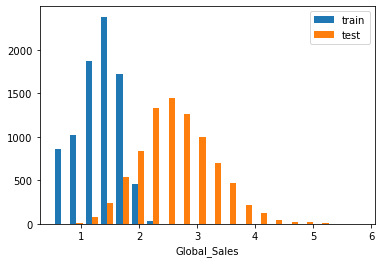

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [17]:
FILENAME = 'submission_cat.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_cat.csv


In [18]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- cat = {:.4f}'.format(score))

- feat = 1452
- mean = 16.5429
- max = 335.4926
- cat = 1.0367


#### 23cat
- feat = 1452
- mean = 16.5429
- max = 335.4926
- cat = 1.0367

#### 22cat: catboost
- feat = 1432
- mean = 24.2944
- max = 516.1847
- cat = 1.0980

#### 21cat: catboost (learning_rate=0.01)
- feat = 1421
- mean = 24.3766
- max = 526.5783
- score = 1.0733
- LB= 0.9055

#### 20cat: catboost
- feat = 1421
- mean = 24.6113
- max = 362.5455
- score = 1.1017
- LB= 0.929

#### 20lgbm
- feat = 1421
- mean = 24.6853
- max = 532.8670
- score = 1.0875

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001　★best★